In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from database_credentials import get_database_url
from load_drop_plot import (
    load_week_n_sell_data,
    drop_incomplete_sell_data,
    plot_sell_data
)

In [2]:
def date_to_weekday_am_pm(date):
    weekday = date.strftime('%A')
    time_of_day = date.strftime('%p')
    
    weekday_am_pm = weekday + ' ' + time_of_day
    return weekday_am_pm

def transform(data):
    """
    
    user_id, island_id -> index indicating trend number
    use datetime_observed to find weekday_observed
    
    """
    data['weekday_observed'] = (
        data['datetime_observed'].apply(date_to_weekday_am_pm)
    )
    
    # include datetime_observed for correct weekday order
    pivot_table = pd.pivot_table(
        data=data,
        values='price',
        index=['user_id', 'island_id'],
        columns=['datetime_observed', 'weekday_observed']
    )
    pivot_table.reset_index(drop=True, inplace=True)
    pivot_table.reset_index(inplace=True)
    
    transformed_data = pivot_table.melt(
        id_vars='index',
        value_name='price'
    )
    
    return transformed_data

def combine(data):
    pivot_tables = [
        pd.pivot_table(
            data=data,
            values='price',
            index='index',
            columns=['datetime_observed', 'weekday_observed']
        ) 
        for data in transformed_sell_data
    ]
    
    combined_data = pd.concat(pivot_tables)
    combined_data.reset_index(drop=True, inplace=True)
    combined_data.reset_index(inplace=True)
    
    combined_data = combined_data.melt(
        id_vars='index',
        value_name='price'
    )

    combined_data.sort_values(
        by=['datetime_observed'], 
        ascending=True, 
        inplace=True
    )
    
    return combined_data

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [5]:
num_weeks = 3

sell_data = [
    load_week_n_sell_data(week=week_num, connection=connection) 
    for week_num in range(1, num_weeks + 1)
]

sell_data = [drop_incomplete_sell_data(data) for data in sell_data]

In [6]:
transformed_sell_data = [transform(data) for data in sell_data]

In [7]:
combined_data = combine(transformed_sell_data)
xticks = combined_data['weekday_observed'].unique()

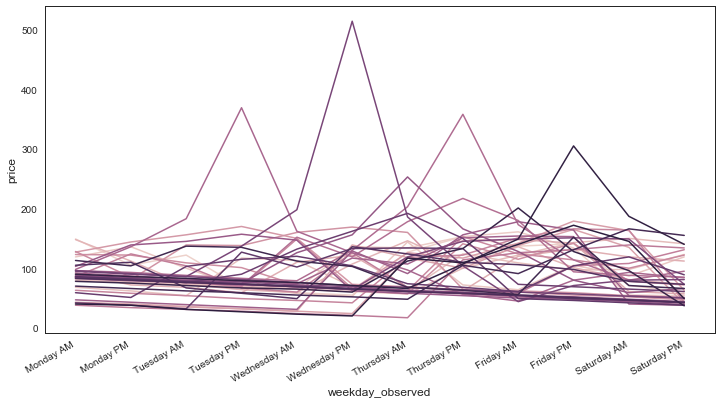

In [9]:
plt.figure(figsize=(12, 6))
b = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='index',
    data=combined_data, 
    sort=False,
    legend=False
)

b.set_xticklabels(xticks, rotation=30, ha='right')
plt.show()